In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 设置字体大小
plt.rcParams['font.size'] = 20
# 加粗图片边框
plt.rcParams['axes.linewidth'] = 2

In [84]:
data_path = r'..\Question\Wimbledon_featured_matches.csv'
data = pd.read_csv(data_path)
print(data.head())

              match_id         player1        player2 elapsed_time  set_no  \
0  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:00       1   
1  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:00:38       1   
2  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:01       1   
3  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:01:31       1   
4  2023-wimbledon-1301  Carlos Alcaraz  Nicolas Jarry     00:02:21       1   

   game_no  point_no  p1_sets  p2_sets  p1_games  ...  p2_break_pt_won  \
0        1         1        0        0         0  ...                0   
1        1         2        0        0         0  ...                0   
2        1         3        0        0         0  ...                0   
3        1         4        0        0         0  ...                0   
4        1         5        0        0         0  ...                0   

  p1_break_pt_missed p2_break_pt_missed  p1_distance_run  p2_distance_run  \
0        

In [85]:
# 按match_id分组
grouped = data.groupby('match_id')
print(grouped.size())

match_id
2023-wimbledon-1301    300
2023-wimbledon-1302    201
2023-wimbledon-1303    134
2023-wimbledon-1304    337
2023-wimbledon-1305    246
2023-wimbledon-1306    332
2023-wimbledon-1307    232
2023-wimbledon-1308    190
2023-wimbledon-1309    213
2023-wimbledon-1310    318
2023-wimbledon-1311    170
2023-wimbledon-1312    275
2023-wimbledon-1313    290
2023-wimbledon-1314    185
2023-wimbledon-1315    198
2023-wimbledon-1316    167
2023-wimbledon-1401    225
2023-wimbledon-1402    274
2023-wimbledon-1403    122
2023-wimbledon-1404    286
2023-wimbledon-1405    215
2023-wimbledon-1406    195
2023-wimbledon-1407    331
2023-wimbledon-1408    271
2023-wimbledon-1501    189
2023-wimbledon-1502    283
2023-wimbledon-1503    193
2023-wimbledon-1504    217
2023-wimbledon-1601    159
2023-wimbledon-1602    202
2023-wimbledon-1701    334
dtype: int64


In [86]:
def analyse_all_match(all_match):
    # 统计所有球员的姓名
    player1 = all_match['player1']
    player2 = all_match['player2']
    player = pd.concat([player1, player2], axis=0)
    # 取唯一值
    player = player.unique()
    # 字典序
    player.sort()
    player2index = {name: i for i, name in enumerate(player)}
    # 构建胜负矩阵
    win_matrix = np.zeros((len(player), len(player)))
    lose_matrix = np.zeros((len(player), len(player)))
    # 遍历每场比赛
    for row in all_match.iterrows():
        # 获取比赛结果
        row = row[1]
        player1 = row['player1']
        player2 = row['player2']
        win_index = row['point_victor']
        winner_index = player2index[player1] if win_index == 1 else player2index[player2]
        loser_index = player2index[player1] if win_index == 2 else player2index[player2]
        # 更新胜负矩阵
        win_matrix[winner_index, loser_index] += 1
        lose_matrix[loser_index, winner_index] += 1
    return win_matrix, lose_matrix, player
win_matrix, lose_matrix, player = analyse_all_match(data)

In [87]:
def cal_likelihood(gamma, win_matrix, lose_matrix):
    likelihood = 0
    for i in range(len(player)):
        for j in range(len(player)):
            if i != j:
                likelihood += win_matrix[i, j] * np.log(gamma[i] / (gamma[i] + gamma[j]))
    return likelihood

def Bradley_Terry(win_matrix, lose_matrix, player, seed=0):
    # 初始化参数, (0, 1) 之间
    gamma = np.random.RandomState(seed).rand(len(player))
    # 迭代次数
    max_iter = 100
    likelihood_list = []
    # 迭代
    for _ in range(max_iter):
        # 更新参数
        gamma_copy = gamma.copy()
        for i in range(len(player)):
            W = np.sum(win_matrix[i, :])
            N = win_matrix[i, :] + lose_matrix[i, :]
            gamma_sum = gamma[i] + gamma
            sum_ = np.sum(N / gamma_sum)
            gamma_copy[i] = W / sum_
        gamma = gamma_copy
        # 计算似然函数值
        likelihood = cal_likelihood(gamma, win_matrix, lose_matrix)
        likelihood_list.append(-likelihood)
    return gamma, likelihood_list


In [88]:
def abbreviate_name(full_name):
    """
    Converts a full name into abbreviated format suitable for academic papers.
    Args:
    - full_name (str): The full name to be abbreviated.
    
    Returns:
    - str: The abbreviated name.
    """
    parts = full_name.strip().split()
    if len(parts) == 1:  # Only last name provided
        return full_name
    else:
        # Abbreviate first and middle names, keep the last name as is
        abbreviated_parts = [f"{part[0]}." for part in parts[:-1]]
        abbreviated_name = " ".join(abbreviated_parts) + " " + parts[-1]
        return abbreviated_name

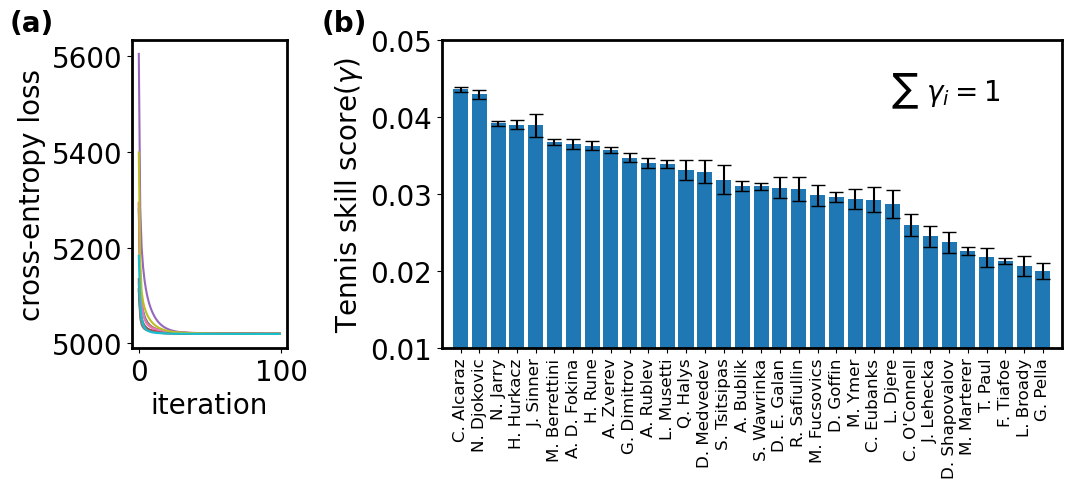

In [107]:
top2name = {
    'TOP1': 'Carlos Alcaraz',
    'TOP2': 'Novak Djokovic',
    'TOP4': ['Jannik Sinner', 'Daniil Medvedev'],
    'TOP8': ['Andrey Rublev', 'Roman Safiullin', 'Christopher Eubanks', 'Holger Rune'],
    'TOP16': ['Hubert Hurkacz', 'Alexander Bublik', 'Denis Shapovalov', 'Daniel Elahi Galan', 'Stefanos Tsitsipas', 'Jiri Lehecka', 'Grigor Dimitrov', 'Matteo Berrettini'],
    'TOP32': ['Stan Wawrinka', 'Lorenzo Musetti', 'Maximilian Marterer', 'David Goffin', 'Liam Broady', 'Guido Pella', 'Mikael Ymer', 'Quentin Halys', 'Laslo Djere', 'Christopher O\'Connell', 'Tommy Paul', 'Marton Fucsovics', 'Alejandro Davidovich Fokina', 'Frances Tiafoe', 'Alexander Zverev', 'Nicolas Jarry']
}
name2top = {
    'Carlos Alcaraz': 'TOP1',
    'Novak Djokovic': 'TOP2',
    'Jannik Sinner': 'TOP4',
    'Daniil Medvedev': 'TOP4',
    'Andrey Rublev': 'TOP8',
    'Roman Safiullin': 'TOP8',
    'Christopher Eubanks': 'TOP8',
    'Holger Rune': 'TOP8',
    'Hubert Hurkacz': 'TOP16',
    'Alexander Bublik': 'TOP16',
    'Denis Shapovalov': 'TOP16',
    'Daniel Elahi Galan': 'TOP16',
    'Stefanos Tsitsipas': 'TOP16',
    'Jiri Lehecka': 'TOP16',
    'Grigor Dimitrov': 'TOP16',
    'Matteo Berrettini': 'TOP16',
    'Stan Wawrinka': 'TOP32',
    'Lorenzo Musetti': 'TOP32',
    'Maximilian Marterer': 'TOP32',
    'David Goffin': 'TOP32',
    'Liam Broady': 'TOP32',
    'Guido Pella': 'TOP32',
    'Mikael Ymer': 'TOP32',
    'Quentin Halys': 'TOP32',
    'Laslo Djere': 'TOP32',
    'Christopher O\'Connell': 'TOP32',
    'Tommy Paul': 'TOP32',
    'Marton Fucsovics': 'TOP32',
    'Alejandro Davidovich Fokina': 'TOP32',
    'Frances Tiafoe': 'TOP32',
    'Alexander Zverev': 'TOP32',
    'Nicolas Jarry': 'TOP32'
}
# 蓝色渐变色，六种
color_list = plt.cm.Blues(np.linspace(0, 1, 6))
top2coloe = {
    'TOP1': color_list[0], 
    'TOP2': color_list[1],
    'TOP4': color_list[2],
    'TOP8': color_list[3],
    'TOP16': color_list[4],
    'TOP32': color_list[5]
}
fondsize = 20
fig, axes = plt.subplots(1, 2, figsize=(12, 4), width_ratios=(1, 4))
# 两个子图间加间距
plt.subplots_adjust(wspace=0.4)
# 人名缩写
abbreviation = [abbreviate_name(name) for name in player]
gamma_list = []
for seed in range(10):
    gamma, likelihood_list = Bradley_Terry(win_matrix, lose_matrix, player, seed)
    gamma = gamma / np.sum(gamma)
    gamma_list.append(gamma)
    axes[0].plot(likelihood_list, label=f'seed={seed}')
axes[0].set_xlabel('iteration', fontsize=fondsize)
axes[0].set_ylabel('cross-entropy loss', fontsize=fondsize)
# axes[0].legend()
axes[0].text(-0.5, 1.1, '(a)', transform=axes[0].transAxes, fontsize=fondsize, weight='bold', va='top', ha='right')


gamma_list = np.array(gamma_list)
# mean, std
gamma_mean = np.mean(gamma_list, axis=0)
gamma_std = np.std(gamma_list, axis=0)

descend_index = np.argsort(-gamma_mean)
gamma_mean = gamma_mean[descend_index]
gamma_std = gamma_std[descend_index]

abbreviation = [abbreviation[i] for i in descend_index]
# ,增加柱子之间的间距
axes[1].bar(np.arange(len(abbreviation)), gamma_mean, yerr=gamma_std, capsize=5)
axes[1].set_xticks(np.arange(len(player)))
# 调整字体大小
axes[1].set_xticklabels(abbreviation, rotation=90, fontsize=12)
axes[1].set_ylim(0.01, 0.05)
axes[1].set_xlim(-1, len(abbreviation))
# axes[1].set_xlabel('player')
axes[1].set_ylabel('Tennis skill score($\gamma$)', fontsize=fondsize)
axes[1].text(-0.12, 1.1, '(b)', transform=axes[1].transAxes, fontsize=fondsize, weight='bold', va='top', ha='right')
# axes[1].legend()
# 右上角加text \sum gaamma = 1
axes[1].text(0.9, 0.9, r'$\sum\ \gamma_i = 1$', transform=axes[1].transAxes, fontsize=fondsize, va='top', ha='right')
# xlabel 上加不同颜色的阴影


plt.show()

In [90]:
# from scipy.optimize import minimize

# def log_likelihood(params, wins, losses):
#     gamma = np.exp(params)
#     likelihood = 0
#     for i in range(len(gamma)):
#         for j in range(len(gamma)):
#             if i != j:
#                 likelihood += wins[i, j] * np.log(gamma[i] / (gamma[i] + gamma[j]))
#     return -likelihood

# def Bradley_Terry(win_matrix, lose_matrix, player):
#     # 使用minimize函数求解
#     gamma = np.ones(len(player))
#     result = minimize(log_likelihood, np.log(gamma), args=(win_matrix, lose_matrix))
#     gamma = np.exp(result.x)
#     return gamma

# gamma_newton = Bradley_Terry(win_matrix, lose_matrix, player)
# gamma_newton = gamma_newton / np.sum(gamma_newton)

In [91]:
# # 比较两种方法的结果
# plt.figure()
# plt.plot(gamma, label='iteration')
# plt.plot(gamma_newton, label='newton')
# plt.legend()


In [ ]:
seed = 50
普通
主场
*Mom 前一场
EWMA 过程
*